In [1]:
from PIL import Image
import numpy as np
import pandas as pd
import skimage.io
import skimage.transform
import matplotlib.pyplot as plt
import keras
import ast
from PIL import Image, ImageDraw 
from dask import bag
import os
from keras import Model, Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization
from io import BytesIO
%matplotlib inline

Using TensorFlow backend.


In [2]:
fnames = ['input/train_simplified/cat.csv', 'input/train_simplified/dog.csv']
cnames = ['countrycode', 'drawing', 'key_id', 'recognized', 'timestamp', 'word']
drawlist = []
for f in fnames[0:]:
    first = pd.read_csv(f, nrows=10) # make sure we get a recognized drawing
    first = first[first.recognized==True].head(5)
    drawlist.append(first)
draw_df = pd.DataFrame(np.concatenate(drawlist), columns=cnames)
draw_df

,countrycode,drawing,key_id,recognized,timestamp,word
0,VE,"[[[130, 113, 99, 109, 76, 64, 55, 48, 48, 51, ...",5201136883597312,True,2017-03-02 23:25:10.074530,cat
1,BR,"[[[222, 196, 176, 173, 179, 191, 233, 251, 255...",4647694628814848,True,2017-03-26 18:43:54.780830,cat
2,RO,"[[[65, 71, 74, 68, 70, 65, 65], [64, 67, 72, 7...",6411036099870720,True,2017-03-18 09:36:08.290570,cat
3,US,"[[[148, 127, 119, 80, 60, 53, 48, 49, 56, 67, ...",6196755135725568,True,2017-01-25 16:05:51.963360,cat
4,ID,"[[[91, 77, 74, 75, 90, 116, 134, 148, 164, 165...",4597292839469056,True,2017-01-29 02:42:16.318460,cat
5,US,"[[[115, 110, 111, 130, 132, 125], [45, 52, 60,...",6718004173733888,True,2017-03-01 21:44:26.601760,dog
6,KR,"[[[66, 65, 72, 81], [48, 11, 0, 41]], [[61, 28...",5319657680535552,True,2017-03-05 10:02:39.659490,dog
7,AE,"[[[149, 138, 119, 107, 97, 52, 51, 59, 76, 98,...",6665679493136384,True,2017-03-05 10:43:54.155920,dog
8,US,"[[[185, 114, 59, 16, 4, 0, 0, 6, 22, 60, 118, ...",6099729773494272,True,2017-03-05 04:37:45.214010,dog
9,US,"[[[96, 98, 73, 50, 30, 19, 0, 2, 13, 23, 68, 1...",4831731276316672,True,2017-03-10 22:40:57.248030,dog


In [3]:
evens = range(0,11,2)
odds = range(1,12, 2)
df1 = draw_df[draw_df.index.isin(evens)]
df2 = draw_df[draw_df.index.isin(odds)]

example1s = [ast.literal_eval(pts) for pts in df1.drawing.values]
example2s = [ast.literal_eval(pts) for pts in df2.drawing.values]

C:\Users\Abir Hassan\Anaconda3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


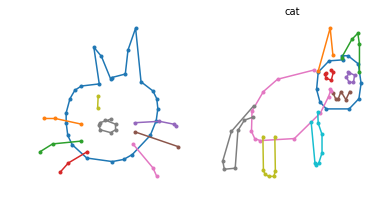

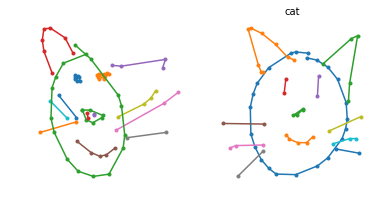

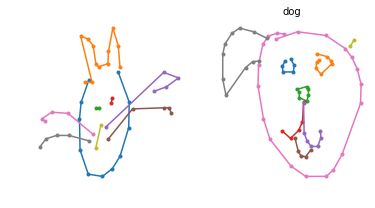

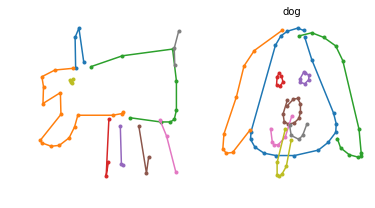

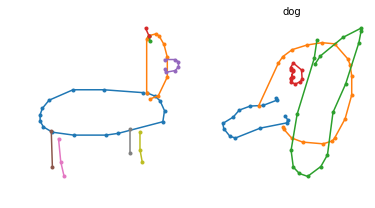

In [4]:
labels = df2.word.tolist()
for i, example in enumerate(example1s):
    plt.figure(figsize=(6,3))
    
    for x,y in example:
        plt.subplot(1,2,1)
        plt.plot(x, y, marker='.')
        plt.gca().invert_yaxis()
        plt.axis('off')

    for x,y, in example2s[i]:
        plt.subplot(1,2,2)
        plt.plot(x, y, marker='.')
        plt.axis('off')
        label = labels[i]
        plt.title(label, fontsize=10)
    plt.gca().invert_yaxis()
    plt.show()  

In [5]:
# faster conversion function
def draw_it(strokes):
    image = Image.new("P", (256,256), color=255)
    image_draw = ImageDraw.Draw(image)
    for stroke in ast.literal_eval(strokes):
        for i in range(len(stroke[0])-1):
            image_draw.line([stroke[0][i], 
                             stroke[1][i],
                             stroke[0][i+1], 
                             stroke[1][i+1]],
                            fill=0, width=5)
    image = image.resize((imheight, imwidth))
    print(np.array(image))
    return np.array(image)/255

In [6]:
#%% get train arrays
train_grand = []
class_paths = fnames
ims_per_class = 2000
num_classes = 2
imheight, imwidth = 32, 32  

for i,c in enumerate(class_paths[0: num_classes]):
    train = pd.read_csv(c, usecols=['drawing', 'recognized'], nrows=ims_per_class*5//4)
    train = train[train.recognized == True].head(ims_per_class)
    imagebag = bag.from_sequence(train.drawing.values).map(draw_it) 
    trainarray = np.array(imagebag.compute())  # PARALLELIZE
    trainarray = np.reshape(trainarray, (ims_per_class, -1))    
    labelarray = np.full((train.shape[0], 1), i)
    trainarray = np.concatenate((labelarray, trainarray), axis=1)
    train_grand.append(trainarray)
    
train_grand = np.array([train_grand.pop() for i in np.arange(num_classes)]) #less memory than np.concatenate
train_grand = train_grand.reshape((-1, (imheight*imwidth+1)))
train_grand

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [0., 1., 1., ..., 1., 1., 1.],
       [0., 1., 1., ..., 1., 1., 1.],
       [0., 1., 1., ..., 1., 1., 1.]])

In [7]:
# memory-friendly alternative to train_test_split?
valfrac = 0.1
cutpt = int(valfrac * train_grand.shape[0])

np.random.shuffle(train_grand)
y_train, X_train = train_grand[cutpt: , 0], train_grand[cutpt: , 1:]
y_val, X_val = train_grand[0:cutpt, 0], train_grand[0:cutpt, 1:] #validation set is recognized==True

del train_grand

y_train = keras.utils.to_categorical(y_train, num_classes)
X_train = X_train.reshape(X_train.shape[0], imheight, imwidth, 1)
y_val = keras.utils.to_categorical(y_val, num_classes)
X_val = X_val.reshape(X_val.shape[0], imheight, imwidth, 1)

print(y_train.shape, "\n",
      X_train.shape, "\n",
      y_val.shape, "\n",
      X_val.shape)

(3600, 2) 
 (3600, 32, 32, 1) 
 (400, 2) 
 (400, 32, 32, 1)


In [8]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(imheight, imwidth, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(680, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 680)               2785960   
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 1362      
Total para

In [9]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.loss = []
        self.val_acc = []
        self.acc = []
        
    def on_batch_end(self, batch, logs={}):
        self.loss.append(logs.get('loss'))
        
    def on_epoch_end(self, epoch, logs):
        self.val_acc.append(logs.get('val_acc'))
        self.acc.append(logs.get('acc'))

history_cb = LossHistory()

In [10]:
from keras import optimizers

opt = optimizers.Adam(lr=0.01)
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [11]:
model.fit(X_train, y_train, epochs=20, batch_size=42, validation_data=(X_val, y_val), callbacks=[history_cb])

Train on 3600 samples, validate on 400 samples
Epoch 1/20
3600/3600 [==============================] - 11s 3ms/step - loss: 7.9361 - acc: 0.4994 - val_loss: 8.2202 - val_acc: 0.4900
Epoch 2/20
3600/3600 [==============================] - 10s 3ms/step - loss: 8.0411 - acc: 0.5011 - val_loss: 8.2202 - val_acc: 0.4900
Epoch 3/20
3600/3600 [==============================] - 10s 3ms/step - loss: 8.0411 - acc: 0.5011 - val_loss: 8.2202 - val_acc: 0.4900
Epoch 4/20
3600/3600 [==============================] - 10s 3ms/step - loss: 8.0411 - acc: 0.5011 - val_loss: 8.2202 - val_acc: 0.4900
Epoch 5/20
3600/3600 [==============================] - 10s 3ms/step - loss: 8.0411 - acc: 0.5011 - val_loss: 8.2202 - val_acc: 0.4900
Epoch 6/20
3600/3600 [==============================] - 10s 3ms/step - loss: 8.0411 - acc: 0.5011 - val_loss: 8.2202 - val_acc: 0.4900
Epoch 7/20
3600/3600 [==============================] - 10s 3ms/step - loss: 8.0411 - acc: 0.5011 - val_loss: 8.2202 - val_acc: 0.4900
Epoch 8/

In [12]:
model.save('test1')
model = keras.models.load_model('test1')

In [13]:
mode21Hist = history_cb

Text(0, 0.5, 'Accuracy')

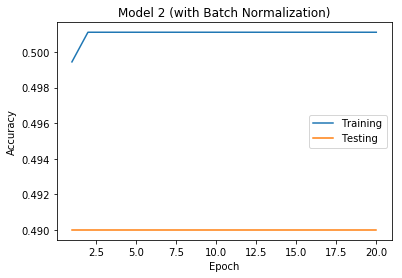

In [14]:
#mode21Hist.acc.append(0.9887)
#mode21Hist.val_acc.append(0.8072)
xVal = np.arange(1, 21, 1)
plt.plot(xVal, mode21Hist.acc)
plt.plot(xVal, mode21Hist.val_acc)
plt.title('Model 2 (with Batch Normalization)')
plt.legend(("Training", "Testing"), loc="best")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

In [15]:
plt.plot(xValLoss, model1Hist.loss)
plt.title('Model 1 (without Batch Normalization)')
plt.legend(("Loss"), loc="best")
plt.xlabel('Batch')
plt.ylabel('Loss')

NameError: name 'xValLoss' is not defined